In [ ]:
# Measurement error mitigation

In [27]:
from qiskit import QuantumCircuit, execute, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import qasm_simulator

import numpy as np

In [ ]:
# First, we create a quantum circuit with some error and see the noisy results

In [6]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

p = 0.02
error_meas = pauli_error([('X',p), ('I', 1 - p)]) # Implements an X-gate with prob. p and Identity with prob. (1-p)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_meas, "measure") # Adding the error to all qubits
# "meas" specifies that a measurement type error will be applied at the time of measurement

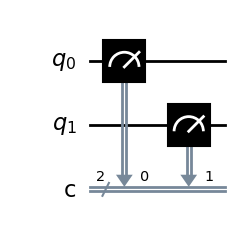

In [7]:
# Create the quantum circuit
qc = QuantumCircuit(2,2)
for i in range(2):
    qc.measure(i,i)
qc.draw()

{'11': 3, '10': 212, '00': 9603, '01': 182}


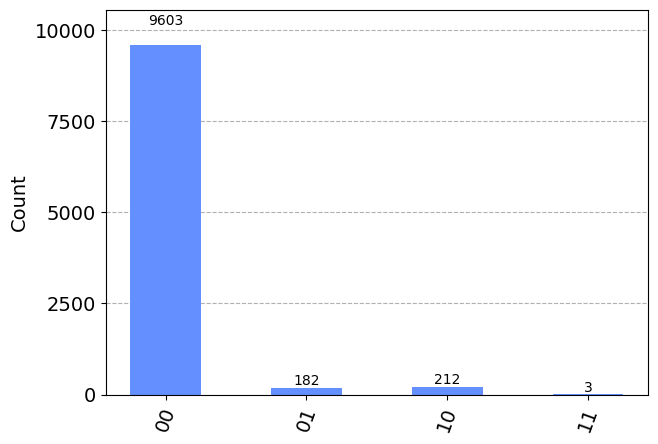

In [8]:
# Run on a simulator with the above error   
simulator = Aer.get_backend('qasm_simulator')
noisy_results = execute(qc, backend = simulator, shots=10000, noise_model = noise_model).result()
noisy_counts=noisy_results.get_counts()
print(noisy_counts)
plot_histogram(noisy_counts)

In [9]:
# We run for all possible initial states |00>, |01>, |10>, |11> to get the matrix M
simulator = Aer.get_backend('qasm_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    
    counts = execute(qc, backend=simulator, shots=10000, noise_model=noise_model).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'11': 8, '01': 189, '00': 9609, '10': 194}
01 becomes {'10': 4, '00': 210, '11': 197, '01': 9589}
10 becomes {'01': 6, '11': 193, '00': 182, '10': 9619}
11 becomes {'01': 172, '00': 5, '10': 191, '11': 9632}


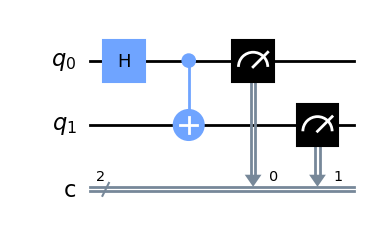

In [10]:
# Let us initiate the state 1/sqrt(2) .(|00> + |11>)
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw()

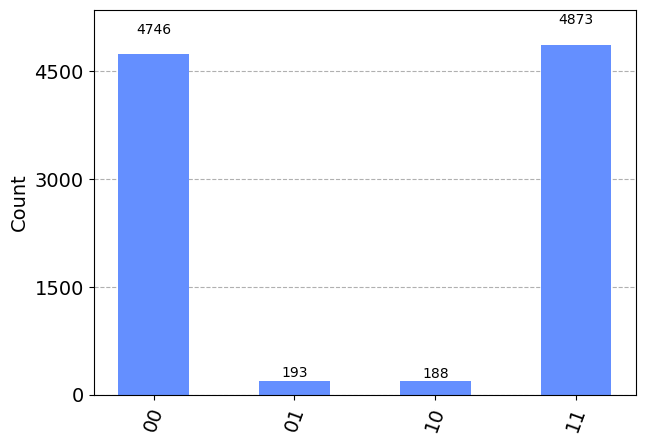

In [11]:
# Results with noise
noisy_results = execute(qc, backend=simulator, shots=10000, noise_model=noise_model).result()
noisy_counts=noisy_results.get_counts()
plot_histogram(noisy_counts)

In [14]:
# Let us try to mitigate this measurement error

In [7]:
pip install qiskit-ignis # The qiskit.ignis module provides tools for quantum error mitigation, characterization etc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 kB 235.1 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
from qiskit import QuantumRegister
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# meas_calibs contains circuits for all possible initial states |00>, |01>, |10>, |11> (state_labels) we ran to get the matrix M

In [13]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q12_0: ─░─┤M├───
        ░ └╥┘┌─┐
q12_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c1: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q12_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q12_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q12_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q12_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q12_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q12_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 



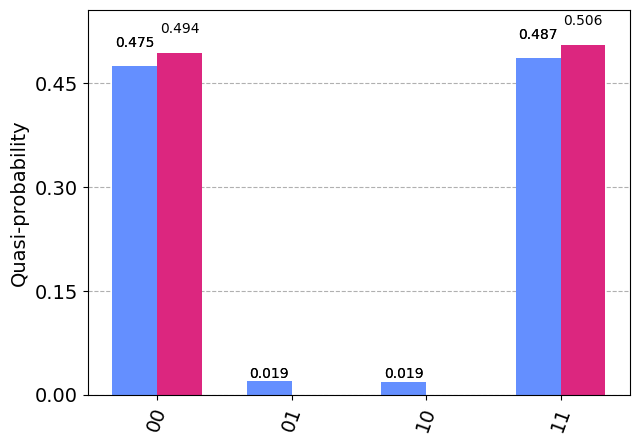

In [14]:
t_qc = transpile(meas_calibs, simulator)
cal_results =execute(t_qc,backend=simulator,noise_model=noise_model, shots=10000).result() # calibrated reults

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter # the M inverse matrix (by extracting data from meas_fitter)

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results) # equivalent to "P_ideal = M^(-1) . P_noisy"
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])

In [15]:
# blue histogram shows noisy results, and red histogram shows mitigated results

In [20]:
# Let us run it on a real quantum computer

In [28]:
# First we run the noisy circuit

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
n = 2
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2023-12-06 15:05:55,349: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_osaka


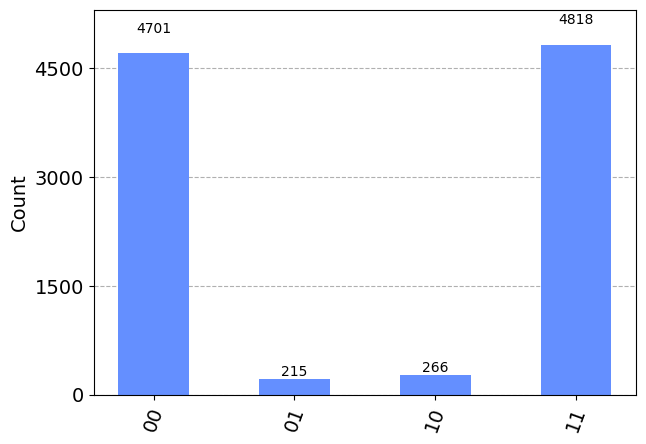

In [29]:
# Run our circuit on the least busy backend, get the results of the computation

noisy_results = execute(qc, backend=backend, shots=10000).result()
noisy_counts=noisy_results.get_counts()
plot_histogram(noisy_counts)

In [30]:
# Now, we run the mitigated circuit

t_qc = transpile(meas_calibs, backend)
cal_results =execute(t_qc,backend=backend, shots=10000).result()

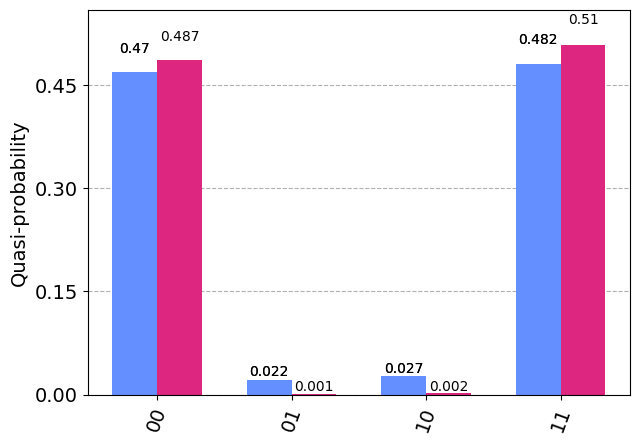

In [31]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])

In [32]:
# We now implement Measurement Error Mitigation in Deutsch-Josza Algorithm

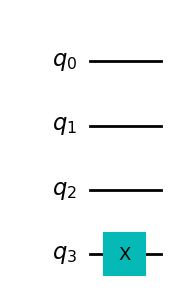

In [33]:
n = 3
f0allx = QuantumCircuit(n+1) # constant oracle for f(x)=0 for all x
f0allx.draw()

f1allx = QuantumCircuit(n+1) # constant oracle for f(x)=1 for all x
f1allx.x(n)
f1allx.draw()

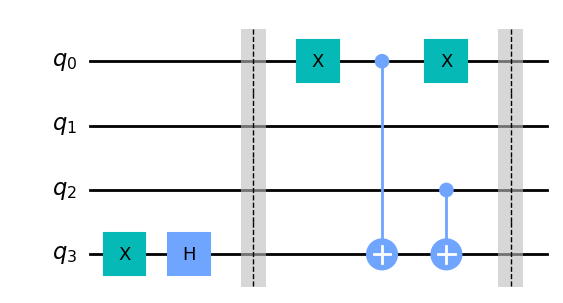

In [34]:
# a balanced oracle

f01half = QuantumCircuit(n+1)
xgates = "100"
cxgates= "101"
# Put ancilia qubit in state |->
f01half.x(n)
f01half.h(n)
f01half.barrier()
# Place X-gates before implementing CX gates in the next loop
for i in range(n):
    if xgates[i] == '1':
        f01half.x(i)
# Place CX-gates to give phase at desired combinations
for m in range(n):
    if cxgates[m] == '1':
        f01half.cx(m,n)
# Place X-gates again to revert to original inputs on 0 to n-1 qubits
for k in range(n):
    if xgates[k] == '1':
        f01half.x(k)
f01half.barrier()
f01half.draw()

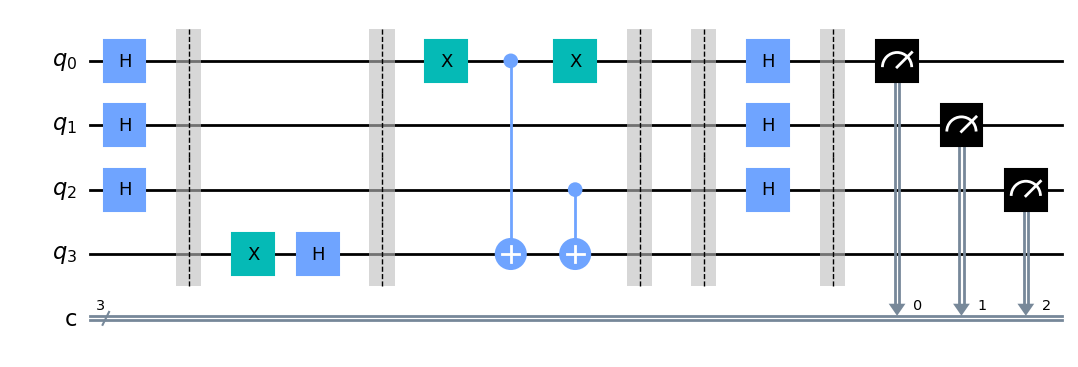

In [35]:
# Creating the DJ circuit

dj_circuit = QuantumCircuit(n+1, n)
# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()
# Add oracle
dj_circuit = dj_circuit.compose(f01half) # DJ circuit for balanced oracle
dj_circuit.barrier()
# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()
# Measure
for i in range(n):
    dj_circuit.measure(i, i)

dj_circuit.draw()

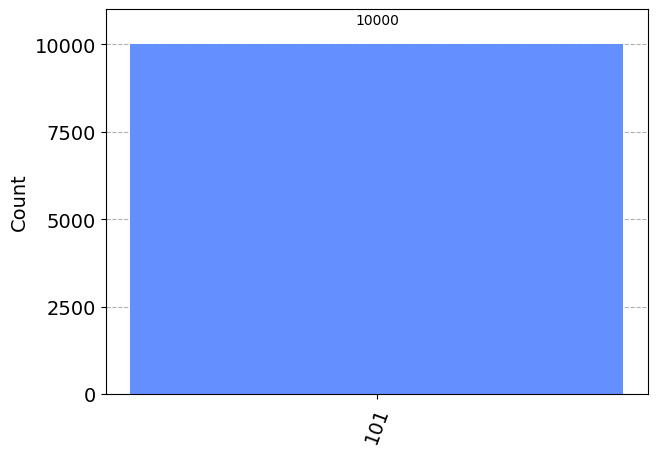

In [36]:
# First, run on a local simulator
backend = Aer.get_backend('qasm_simulator')
results = execute(dj_circuit, backend=backend, shots=10000).result()
answer = results.get_counts()

plot_histogram(answer)

In [37]:
# Now run on a real quantum computer

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2023-12-06 15:09:35,879: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_osaka


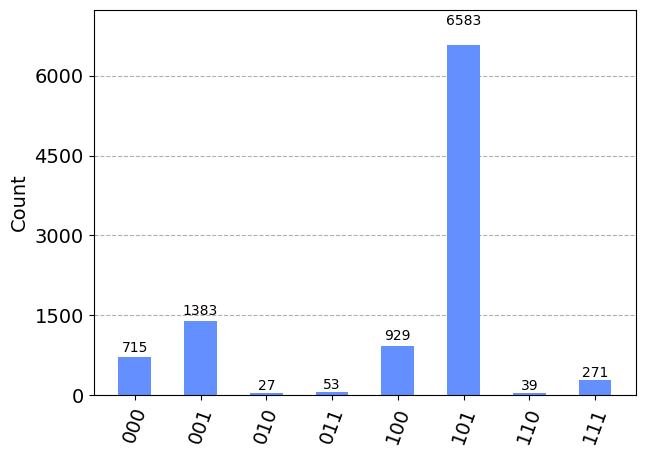

In [38]:
# first for noisy circuit
noisy_results = execute(dj_circuit, backend=backend, shots=10000).result()
noisy_counts = noisy_results.get_counts()
plot_histogram(noisy_counts)

In [39]:
# then for mitigated circuit
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
t_qc = transpile(meas_calibs, backend)
cal_results =execute(t_qc,backend=backend, shots=10000).result()

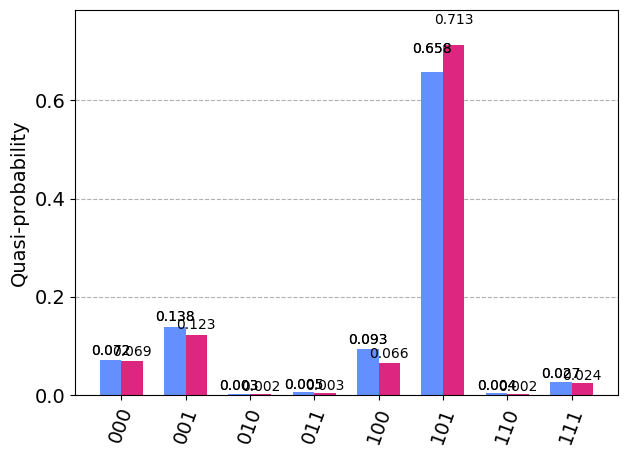

In [40]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])

In [41]:
# As we can see, mitigating measurement error gave better probability of measuring the correct state
# The other errors are due to the algorithmic complexity, like pauli gates, qubit operations etc.